## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import lsdb

from dask.distributed import Client
from io import StringIO
from nested_pandas import NestedDtype, read_parquet
from pathlib import Path

import warnings

# Disable plotting warnings
warnings.filterwarnings("ignore")

In [3]:
lsdb.__version__

'0.6.0'

In [2]:
pd.set_option('display.max_columns', 100)
# CAT_COLORS = {'2SXPS':'tab:blue', '4XMMDR14':'tab:orange', 'CSC2.1':'tab:green', 'eRASS1':'tab:red', 'XMMSL3':'tab:purple'}
# COLORS = {
#     "u": "#56b4e9",
#     "g": "#009e73",
#     "r": "#f0e442",
#     "i": "#cc79a7",
#     "z": "#d55e00",
#     "y": "#0072b2",
# }

In [5]:
obj = read_parquet('../data/obj_dp1_xmatch_control.parquet')
dia = read_parquet('../data/dia_dp1_xmatch_control.parquet')

## Get diaObject Mags from diaObjectforcedSource

In [6]:
def get_dia_phot(df):
    FLUX_OR_MAG='Mag'
    flux_or_mag=FLUX_OR_MAG
    results = {}
    
    if df is None:
        return {f'{band}_psf{flux_or_mag}':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_psf{flux_or_mag}'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()
        inv_var = 1 / errors ** 2

        mean = np.average(fluxes, weights=inv_var)
        results[f'{band}_psf{flux_or_mag}'] = mean
        
    return results

In [7]:
diaPhot = dia.reduce(get_dia_phot, ('diaObjectForcedSource'))

In [8]:
for col in diaPhot.columns:
    dia[col] = diaPhot[col]

## Get StetsonJs

In [9]:
# adapted from https://github.com/lsst/meas_base/blob/e5cf12406b54a6312b9d6fa23fbd132cd7999387/python/lsst/meas/base/diaCalculationPlugins.py#L887

def stetson_mean(values,
                  errors,
                  mean=None,
                  alpha=2.,
                  beta=2.,
                  n_iter=20,
                  tol=1e-6):
    """Compute the stetson mean of the fluxes which down-weights outliers.

    Weighted biased on an error weighted difference scaled by a constant
    (1/``a``) and raised to the power beta. Higher betas more harshly
    penalize outliers and ``a`` sets the number of sigma where a weighted
    difference of 1 occurs.

    Parameters
    ----------
    values : `numpy.dnarray`, (N,)
        Input values to compute the mean of.
    errors : `numpy.ndarray`, (N,)
        Errors on the input values.
    mean : `float`
        Starting mean value or None.
    alpha : `float`
        Scalar down-weighting of the fractional difference. lower->more
        clipping. (Default value is 2.)
    beta : `float`
        Power law slope of the used to down-weight outliers. higher->more
        clipping. (Default value is 2.)
    n_iter : `int`
        Number of iterations of clipping.
    tol : `float`
        Fractional and absolute tolerance goal on the change in the mean
        before exiting early. (Default value is 1e-6)

    Returns
    -------
    mean : `float`
        Weighted stetson mean result.

    References
    ----------
    .. [1] Stetson, P. B., "On the Automatic Determination of Light-Curve
       Parameters for Cepheid Variables", PASP, 108, 851S, 1996
    """
    n_points = len(values)
    n_factor = np.sqrt(n_points / (n_points - 1))
    inv_var = 1 / errors ** 2

    if mean is None:
        mean = np.average(values, weights=inv_var)
    for iter_idx in range(n_iter):
        chi = np.fabs(n_factor * (values - mean) / errors)
        tmp_mean = np.average(
            values,
            weights=inv_var / (1 + (chi / alpha) ** beta))
        diff = np.fabs(tmp_mean - mean)
        mean = tmp_mean
        if diff / mean < tol and diff < tol:
            break
    return mean
    
def _stetson_J(fluxes, errors, mean=None):
        """Compute the single band stetsonJ statistic.

        Parameters
        ----------
        fluxes : `numpy.ndarray` (N,)
            Calibrated lightcurve flux values.
        errors : `numpy.ndarray` (N,)
            Errors on the calibrated lightcurve fluxes.
        mean : `float`
            Starting mean from previous plugin.

        Returns
        -------
        stetsonJ : `float`
            stetsonJ statistic for the input fluxes and errors.

        References
        ----------
        .. [1] Stetson, P. B., "On the Automatic Determination of Light-Curve
           Parameters for Cepheid Variables", PASP, 108, 851S, 1996
        """
        n_points = len(fluxes)
        flux_mean = stetson_mean(fluxes, errors, mean)
        delta_val = (
            np.sqrt(n_points / (n_points - 1)) * (fluxes - flux_mean) / errors)
        p_k = delta_val ** 2 - 1

        return np.mean(np.sign(p_k) * np.sqrt(np.fabs(p_k)))
    
def rubin_stetsonJ(df):
    results = {}
    flux_or_mag = 'Flux'
    if df is None:
        return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 2:
            results[f'{band}_psfFluxForcedStetsonJ'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()

        results[f'{band}_psfFluxForcedStetsonJ'] = _stetson_J(
            fluxes,
            errors)
    return results





In [10]:
objJs = obj.reduce(rubin_stetsonJ, ("objectForcedSource"))
diaJs = dia.reduce(rubin_stetsonJ, ("diaObjectForcedSource"))

for col in diaJs.columns:
    dia[col] = diaJs[col]

for col in objJs.columns:
    obj[col] = objJs[col]

In [11]:
dia

name_X       ra_X      dec_X  e_pos_raw_X      field_X  \
0      2SXPS J023340.9+065611    38.4208     6.9366          3.5      SV_38_7   
1      2SXPS J023340.9+065611    38.4208     6.9366          3.5      SV_38_7   
...                       ...        ...        ...          ...          ...   
17479   4XMM J023854.8-342127  39.728545 -34.357632     2.369756  Fornax_dSph   
17480   4XMM J023914.1-342927  39.808834 -34.491031     3.448449  Fornax_dSph   

          cat_X  F_X  e_pos_1sig_X  e_pos_95_X obj_flag_X dia_flag_X  tract_X  \
0         2SXPS  0.0       2.12766    4.170213       True       True    10464   
1         2SXPS  0.0       2.12766    4.170213       True       True    10464   
...         ...  ...           ...         ...        ...        ...      ...   
17479  4XMMDR14  0.0      2.369756    4.644723      False       True     4016   
17480  4XMMDR14  0.0      3.448449    6.758961      False       True     4016   

       patch_X DP1_flag_X        dec         diaObjectId  nDiaSources  \
0           67       True   6.934395  648373416964915245            1   
1           67       True   6.934172  648373416964915307            1   
...        ...        ...        ...                 ...          ...   
17479       83       True -34.355597  604064197877171171            1   
17480       72       True -34.487571  604063441962931821            1   

              ra   radecMjdTai  tract  \
0      38.421742   60638.12089  10464   
1      38.420067  60638.131253  10464   
...          ...           ...    ...   
17479  39.732308  60639.271225   4016   
17480  39.810968  60650.180769   4016   

                                   diaObjectForcedSource  \
0      [{parentObjectId: 0, coord_ra: 38.421742, coor...   
1      [{parentObjectId: 0, coord_ra: 38.420067, coor...   
...                                                  ...   
17479  [{parentObjectId: 0, coord_ra: 39.732308, coor...   
17480  [{parentObjectId: 0, coord_ra: 39.810968, coor...   

                                               diaSource  g_psfFluxStetsonJ  \
0      [{visit: 2024112300213, detector: 2, band: 'r'...               <NA>   
1      [{visit: 2024112300229, detector: 2, band: 'i'...               <NA>   
...                                                  ...                ...   
17479  [{visit: 2024112400276, detector: 0, band: 'i'...               <NA>   
17480  [{visit: 2024120500027, detector: 1, band: 'g'...               <NA>   

       r_psfFluxStetsonJ  u_psfFluxStetsonJ  i_psfFluxStetsonJ  \
0                   <NA>               <NA>               <NA>   
1                   <NA>               <NA>               <NA>   
...                  ...                ...                ...   
17479               <NA>               <NA>               <NA>   
17480               <NA>               <NA>               <NA>   

       z_psfFluxStetsonJ  y_psfFluxStetsonJ  _dist_arcsec  \
0                   <NA>               <NA>      8.621714   
1                   <NA>               <NA>      9.125684   
...                  ...                ...           ...   
17479               <NA>               <NA>     13.369326   
17480               <NA>               <NA>     13.971821   

               _healpix_29  __index_level_0__  u_psfMag   g_psfMag   r_psfMag  \
0         9652568135954894                 19       NaN  25.477913  21.959024   
1         9652568135954894                 20       NaN  25.178637  24.405775   
...                    ...                ...       ...        ...        ...   
17479  2531132050414730034              23434       NaN  20.411957  20.119194   
17480  2531129652620208164              23443       NaN  25.638151  24.163406   

        i_psfMag  z_psfMag  y_psfMag  u_psfFluxForcedStetsonJ  \
0      24.931753       NaN       NaN                      NaN   
1      21.720390       NaN       NaN                      NaN   
...          ...       ...       ...                      ...   
17479  19.526987

### Get number of obs in forcedPhotometry

In [12]:
def nForced(df):
    results = {}
    flux_or_mag = 'Mag'
    if df is None:
        return {f'{band}_nForced':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_nForced'] = int(0)
            continue

        results[f'{band}_nForced'] = int(len(tmpDf))
        
    return results

In [13]:
objNs = obj.reduce(nForced, ("objectForcedSource"))

diaNs = dia.reduce(nForced, ("diaObjectForcedSource"))

for col in diaNs.columns:
    dia[col] = diaNs[col]

for col in objNs.columns:
    obj[col] = objNs[col]

## Get optical fluxes in erg/s/cm**2

In [14]:
def combine_nJy_flux(df, suffix='_psfFlux'):
    """
    Combine LSST filter fluxes in nanojanskys into total flux in erg/s/cm^2,
    using Astropy for unit handling.

    Returns:
        total_flux (Quantity): Combined flux in erg/s/cm^2 (Astropy Quantity)
    """

    # LSST central wavelengths and bandwidths in nm
    filters = {
        'u': (367, 40),
        'g': (482, 137),
        'r': (622, 132),
        'i': (754, 127),
        'z': (869, 118),
        'y': (971, 65),
    }

    total_flux = 0.0 * u.erg / u.s / u.cm**2
    from astropy.constants import c


    for band in 'ugrizy':
        # try: 
            f_nJy = df[band+suffix]
            if pd.isna(f_nJy):
                f_nJy = 0.0 * u.nJy
            else:
                f_nJy = f_nJy * u.nJy
            lambda_eff_nm, delta_lambda_nm = filters[band]
    
            lambda_eff = lambda_eff_nm * u.nm
            delta_lambda = delta_lambda_nm * u.nm
    
            # Convert wavelength to frequency bandwidth using Δν = c * Δλ / λ^2
            delta_nu = (c * delta_lambda / lambda_eff**2).to(u.Hz)
    
            # Convert nJy to erg/s/cm^2/Hz
            f_nu = f_nJy.to(u.erg / u.s / u.cm**2 / u.Hz)
            
            # Total flux in this band: F = f_nu × Δν
            flux_band = f_nu * delta_nu
    
            total_flux += flux_band
        # except:
        #     import pdb; pdb.set_trace()

    return total_flux

In [15]:
F_opt = []
for _, row in obj.iterrows():
    F_opt.append(combine_nJy_flux(row).to(u.erg / u.s / u.cm**2))
F_opt = [x.value for x in F_opt]

obj['F_opt'] = F_opt

In [16]:
def get_dia_phot(df):
    flux_or_mag='Flux'
    results = {}
    
    if df is None:
        return {f'{band}_psf{flux_or_mag}':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_psf{flux_or_mag}'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()
        inv_var = 1 / errors ** 2

        mean = np.average(fluxes, weights=inv_var)
        results[f'{band}_psf{flux_or_mag}'] = mean
        
    return results

diaPhot = dia.reduce(get_dia_phot, ('diaObjectForcedSource'))

In [17]:
diaPhot

,u_psfFlux,g_psfFlux,r_psfFlux,i_psfFlux,z_psfFlux,y_psfFlux
0,NaN,53.347294,738.931396,32.703743,-31.446144,NaN
1,NaN,103.244865,77.644684,780.951416,143.470245,NaN
...,...,...,...,...,...,...
17479,NaN,24325.849609,30578.652344,51983.082031,NaN,NaN
17480,NaN,186.106064,753.013855,814.046204,NaN,NaN


In [18]:
F_opt_dia = []
for _, row in diaPhot.iterrows():
    F_opt_dia.append(combine_nJy_flux(row).to(u.erg / u.s / u.cm**2))
F_opt_dia = [x.value for x in F_opt_dia]

# obj['F_opt'] = F_opt

In [19]:
dia['F_opt'] = F_opt_dia

### Save to parquet

In [20]:
dia.to_parquet('../data/dia_dp1_xmatch_control_added.parquet')
obj.to_parquet('../data/obj_dp1_xmatch_control_added.parquet')

### Crossmatch to Luo 2017

## Crossmatch to milliQuas

In [24]:
miliquas_cat = lsdb.read_hats(
    "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
    margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
)

FileNotFoundError: Failed to read HATS at location /sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8

In [10]:
result['ra'] = result['coord_ra']
result['dec'] = result['coord_dec']

In [11]:
result


KeyboardInterrupt



In [100]:
comcam_pos = pd.DataFrame(result[['ra', 'dec', 'objectId', 'field_X', 'name_X', 'cat_X']])
comcam_pos = lsdb.from_dataframe(comcam_pos)

In [101]:

result_x_milliquas = comcam_pos.crossmatch(miliquas_cat, suffixes=["", "_MIL"], radius_arcsec=.99)


In [102]:
result_x_milliquas = result_x_milliquas.compute()


In [103]:
result_x_milliquas['field_X'].value_counts()

field_X
ECDFS      436
SV_38_7      5
EDFS         3
47Tuc        2
Name: count, dtype: int64[pyarrow]

In [104]:
result_x_milliquas['cat_X'].value_counts()

cat_X
CSC2.1      320
4XMMDR14    116
2SXPS         6
eRASS1        4
Name: count, dtype: int64[pyarrow]

<Axes: >

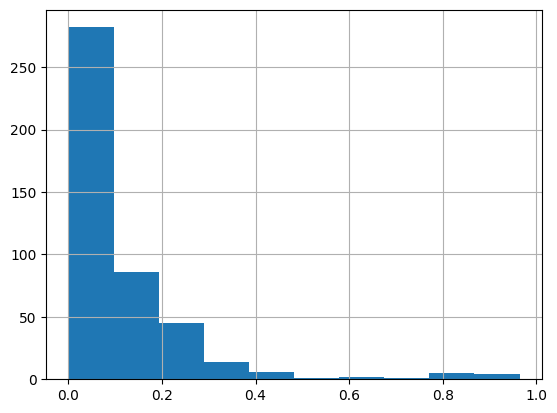

In [105]:
result_x_milliquas['_dist_arcsec'].hist()

In [106]:
pd.DataFrame(result_x_milliquas).to_csv('data/obj_x_milliquas.csv', index=False)

## Query SIMBAD

In [23]:
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord

In [ ]:
from time import sleep
from random import random

In [80]:
customSimbad=Simbad()
customSimbad.TIMEOUT = 600
customSimbad.add_votable_fields("otype(V)")
customSimbad.add_votable_fields("otype(3)")
# customSimbad.add_votable_fields("otype(N)")
# customSimbad.add_votable_fields("otype(S)")


customSimbad.add_votable_fields("flux(u)")
customSimbad.add_votable_fields("flux(g)")
customSimbad.add_votable_fields("flux(r)")
customSimbad.add_votable_fields("flux(i)")
# customSimbad.add_votable_fields("flux(z)")
# customSimbad.add_votable_fields("flux(y)")

In [66]:
customSimbad=Simbad()
customSimbad.add_votable_fields("ident")

In [71]:
c = SkyCoord(38.054382*u.degree, 6.830891*u.degree)

In [68]:
result


KeyboardInterrupt



In [85]:
for ii in range 
test = customSimbad.query_region(sc[:500], radius=2*u.arcsecond)

In [87]:
test.to_pandas()

,main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,otypedef.otype,otypedef.comment,otypedef.description,otypedef.is_candidate,otypedef.label,otypedef.otype_longname,otypedef.otype_shortname,otypedef.path,otype,u,g,r,i
0,ATO J094.6486-24.8319,94.648776,-24.832000,0.0078,0.0101,90,O,2020yCat.1350....0G,EB?,,Eclipsing Binary Candidate,1,EclBin_Candidate,Eclipsing Binary Candidate,EB?,* > ** > EB*,EB?,NaN,NaN,NaN,NaN
1,CD-49 1138,58.647610,-49.324666,0.0225,0.0219,90,O,2020yCat.1350....0G,*,,Star,0,Star,Star,*,*,*,NaN,10.765,9.809,9.464
2,TYC 6510-1535-1,95.334704,-25.016426,0.0068,0.0088,90,O,2020yCat.1350....0G,*,,Star,0,Star,Star,*,*,*,NaN,NaN,NaN,NaN
3,DENIS J061938.4-250957,94.910385,-25.165897,0.0056,0.0074,90,O,2020yCat.1350....0G,LP?,,Long-Period Variable Candidate,1,LongPeriodV*_Candidate,Long-Period Variable Candidate,LP?,* > Ev* > LP*,LP?,NaN,13.300,12.380,12.060
4,TYC 6510-1462-1,94.413381,-24.738495,0.0536,0.0703,90,O,2020yCat.1350....0G,SB*,,Spectroscopic Binary,0,SB*,Spectroscopic Binary,SB*,* > ** > SB*,SB*,NaN,12.440,11.690,11.440
5,2MASX J02324626+0637429,38.192642,6.628482,14.1429,10.8143,90,O,2020yCat.1350....0G,G,,Galaxy,0,Galaxy,Galaxy,G,G,G,NaN,NaN,NaN,NaN
6,2MASS J02321305+0649513,38.054380,6.830880,0.1256,0.1168,90,O,2020yCat.1350....0G,QSO,,Quasar,0,QSO,Quasar,QSO,G > AGN > QSO,QSO,NaN,NaN,NaN,NaN
7,HD 1446,4.510683,-71.856696,0.1266,0.1338,90,O,2020yCat.1350....0G,SB*,,Spectroscopic Binary,0,SB*,Spectroscopic Binary,SB*,* > ** > SB*,SB*,NaN,NaN,NaN,NaN
8,SRGE J001805.8-715552,4.527259,-71.931713,0.1766,0.1822,90,O,2020yCat.1350....0G,QSO,,Quasar,0,QSO,Quasar,QSO,G > AGN > QSO,QSO,NaN,NaN,NaN,NaN


In [93]:
end = len(sc)
n = 0
dfs = []
batch = 500
while n < end + batch:
    print(n*batch)
    if n > end:
        break
    else:
        query_df = (customSimbad.query_region(sc[n:min(n+batch, end)], radius=2*u.arcsecond))
    if query_df is None:
        n += batch
        continue
    else:
        query_df = query_df.to_pandas()

    dfs.append(query_df)
    n += batch
simbad_matches = pd.concat(dfs)

0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000


In [95]:
simbad_matches['otype'].value_counts()

otype
G      636
AGN    363
QSO    163
EmG    158
X       43
Sy2     36
*       34
?       32
Rad     11
GiC      6
IR       6
Q?       5
Sy1      4
SB*      3
**       3
rG       2
SN*      2
LP?      1
EB?      1
PM*      1
CV*      1
EB*      1
BLL      1
GiP      1
IG       1
Name: count, dtype: int64

In [98]:
result.head()

name_X       ra_X   dec_X  \
_healpix_29                                                                     
9638386096724690  XMMSL3 J023130.3+065916                   37.876569  6.9877   
9638386096724690  XMMSL3 J023130.3+065916                   37.876569  6.9877   
9638386096724690  XMMSL3 J023130.3+065916                   37.876569  6.9877   
9638386096724690  XMMSL3 J023130.3+065916                   37.876569  6.9877   
9638386096724690  XMMSL3 J023130.3+065916                   37.876569  6.9877   

                  e_pos_raw_X  field_X   cat_X  F_X  e_pos_1sig_X  e_pos_95_X  \
_healpix_29                                                                     
9638386096724690     5.768031  SV_38_7  XMMSL3  0.0      5.768031   11.305341   
9638386096724690     5.768031  SV_38_7  XMMSL3  0.0      5.768031   11.305341   
9638386096724690     5.768031  SV_38_7  XMMSL3  0.0      5.768031   11.305341   
9638386096724690     5.768031  SV_38_7  XMMSL3  0.0      5.768031   11.305341   
9638386096724690     5.768031  SV_38_7  XMMSL3  0.0      5.768031   11.305341   

                             objectId   refFwhm shape_flag  \
_healpix_29                                                  
9638386096724690  4601944345405306923  0.944231      False   
9638386096724690  4601944345405306925  0.888496       True   
9638386096724690  4601944345405306924  0.886328      False   
9638386096724690  4601944345405306649  0.887446      False   
9638386096724690  4601944345405306668  0.890228      False   

                       parentObjectId            x             y      xErr  \
_healpix_29                                                                  
9638386096724690  4601944345405295227  5478.685384  20294.211233   0.15191   
9638386096724690  4601944345405295227       5506.0       20289.0  1.554593   
9638386096724690  4601944345405295227  5472.219736  20301.432383  0.085191   
9638386096724690  4601944345405295094  5464.692574  20251.510571  0.388235   
9638386096724690  4601944345405295094  5480.216532  20233.225732  0.911536   

                      yErr   shape_yy   shape_xx  shape_xy   coord_ra  \
_healpix_29                                                             
9638386096724690  0.144001  11.030074  13.863507 -2.428254  37.877241   
9638386096724690  2.146513  46.455521   6.400945 -6.868353  37.875712   
9638386096724690  0.100712  10.496425   7.466928  0.861861  37.877603   
9638386096724690  0.382358  12.791795  15.676934   1.22956  37.878022   
9638386096724690  0.888917  10.138282  11.393218  3.147218  37.877152   

                  coord_dec  coord_raErr  coord_decErr  tract  patch  \
_healpix_29                                                            
9638386096724690   6.988091     0.000008      0.000008  10463     61   
9638386096724690   6.987804     0.000086      0.000119  10463     61   
9638386096724690   6.988492     0.000005      0.000006  10463     61   
9638386096724690   6.985719     0.000021      0.000021  10463     61   
9638386096724690   6.984704      0.00005      0.000049  10463     61   

                 detect_isIsolated  u_psfFlux  u_psfFluxErr  u_kronFlux  \
_healpix_29                                                               
9638386096724690             False       <NA>          <NA>        <NA>   
9638386096724690             False       <NA>          <NA>        <NA>   
9638386096724690             False       <NA>          <NA>        <NA>   
9638386096724690             False       <NA>          <NA>        <NA>   
9638386096724690             False       <NA>          <NA>        <NA>   

                  u_kronFluxErr  u_kronRad    g_psfFlux  g_psfFluxErr  \
_healpix_29                                                             
9638386096724690           <NA>       <NA>  2368.276855     50.583019   
9638386096724690           <NA>       <NA>    82.597038     49.133499   
9638386096724690           <NA>       <NA>    10.288815      49.13763   
9638386096724690          

In [99]:
simbad_catalog = lsdb.from_dataframe(simbad_matches)

In [122]:
result_x_simbad = simbad_catalog.crossmatch(comcam_pos, suffixes=["_SIM", ""], radius_arcsec=2, n_neighbors=1)

In [119]:
len(simbad_catalog)

1515

In [124]:
result_x_simbad=result_x_simbad.compute()

In [125]:
pd.DataFrame(result_x_simbad).to_csv('data/obj_x_simbad.csv', index=False)

## Make summary plots

In [7]:
result['cat_X'].value_counts()

cat_X
4XMMDR14    2270
eRASS1      1391
CSC2.1       879
XMMSL3       268
2SXPS         54
Name: count, dtype: int64[pyarrow]

In [8]:
result['field_X'].value_counts()

field_X
ECDFS          3496
EDFS            582
SV_95_25        332
Fornax_dSph     320
47Tuc            75
SV_38_7          57
Name: count, dtype: int64[pyarrow]

In [9]:
n_matches_xray = result.groupby('name_X')['objectId'].count()
n_matches_xray.value_counts()

objectId
1     1607
2      292
3      146
10      77
4       68
5       53
6       41
8       32
7       31
9       23
Name: count, dtype: int64[pyarrow]

In [10]:
n_matches_xray.sum()

4862

In [11]:
n_matches_xray.value_counts().sum()

2370

<Axes: >

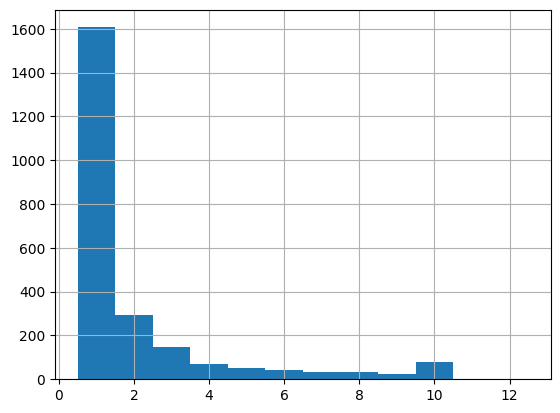

In [12]:
n_matches_xray.hist(bins=np.linspace(.5, 12.5, 13))

In [15]:
def plot_errors_by_col(df, ax, col):
    # Group values by catalog
    groups = df[col].unique()
    # ['2SXPS', '4XMMDR14', 'CSC2.1', 'XMMSL3', 'eRASS1']
    grouped_values = [df[df['cat_X'] == c]['e_pos_95_X'] for c in groups]
    
    # Plot stacked histogram
    ax.hist(grouped_values, 
             bins=15, 
             stacked=True, 
             label=groups, 
             alpha=0.7, histtype='step',  linewidth=4)


In [20]:
# fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(6,12))
# for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
#     matches_field = result.query(f'field_X == "{field}"')[['cat_X', 'e_pos_95_X']]
#     plot_errors_by_cat(matches_field, ax=axs[i])
#     axs[i].set_title(field)
# plt.suptitle('Histogram of 95% CI by DP1 Field')
# plt.xlabel('95% CI [$arcsec$]')
# plt.legend()
# plt.tight_layout()

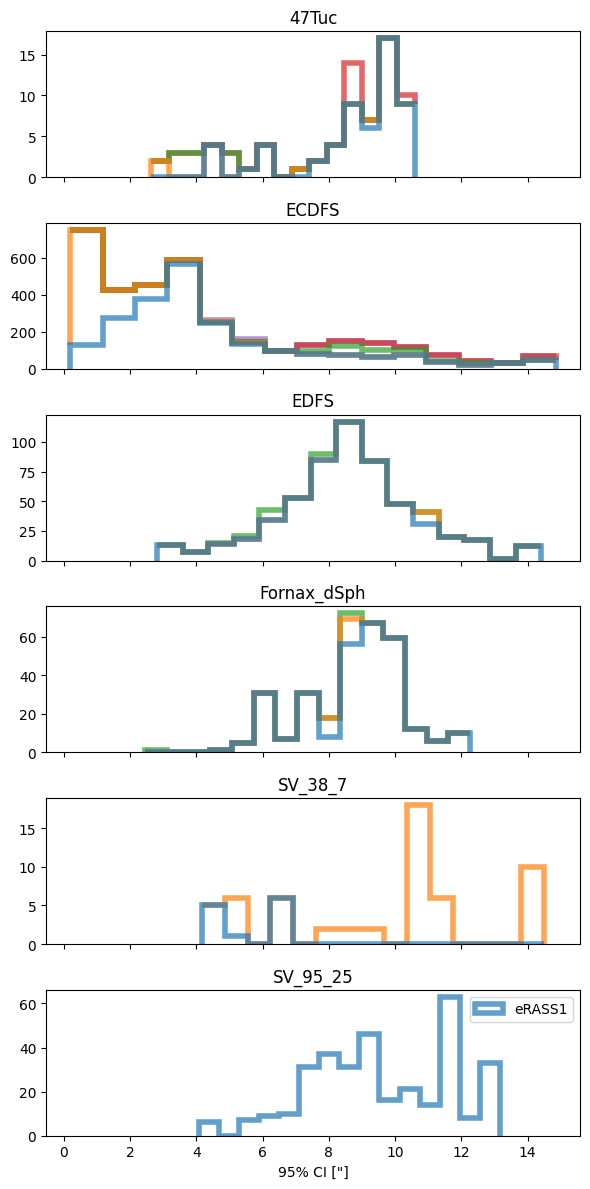

In [17]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(6,12))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    matches_field = result.query(f'field_X == "{field}"')[['cat_X', 'e_pos_95_X']]
    plot_errors_by_col(matches_field, ax=axs[i], col='cat_X')
    axs[i].set_title(field)
# plt.suptitle('Histogram of X-ray Objects by the Number of Matches')
plt.xlabel('95% CI ["]')
plt.legend()
plt.tight_layout()

In [18]:
len(result['name_X'].unique())

2370

## Optical flux plots

### plot stetsonJs

In [304]:
obj = read_parquet('../data/obj_dp1_xmatch_added.parquet')
dia = read_parquet('../data/dia_dp1_xmatch_added.parquet')


In [143]:
obj['dia_flag_X']

0        True
1        True
        ...  
4860    False
4861    False
Name: dia_flag_X, Length: 4862, dtype: bool[pyarrow]

Text(0.5, 0, 'StetsonJ')

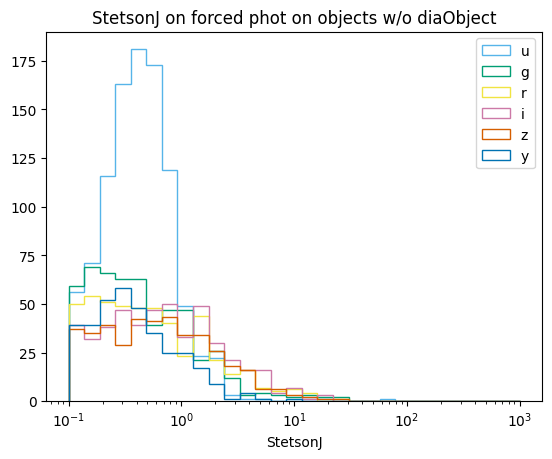

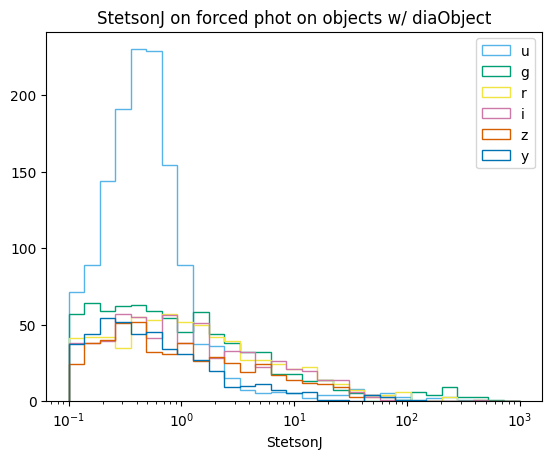

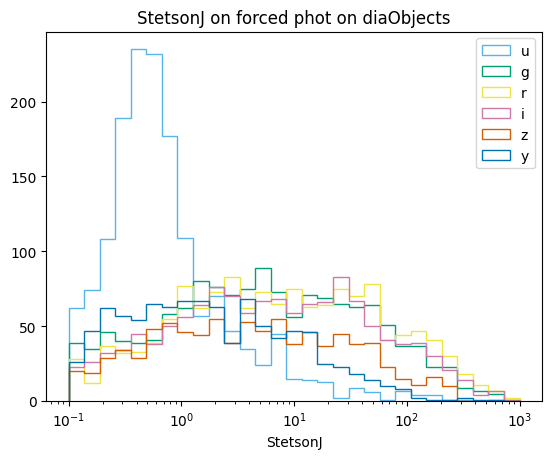

In [260]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(objJs[~obj['dia_flag_X']][col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.xlabel('StetsonJ')
plt.title('StetsonJ on forced phot on objects w/o diaObject')

plt.figure()
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(objJs[obj['dia_flag_X']][col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on objects w/ diaObject')
plt.xlabel('StetsonJ')

plt.figure()
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(diaJs[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on diaObjects')
plt.xlabel('StetsonJ')

Text(0.5, 0, 'StetsonJ')

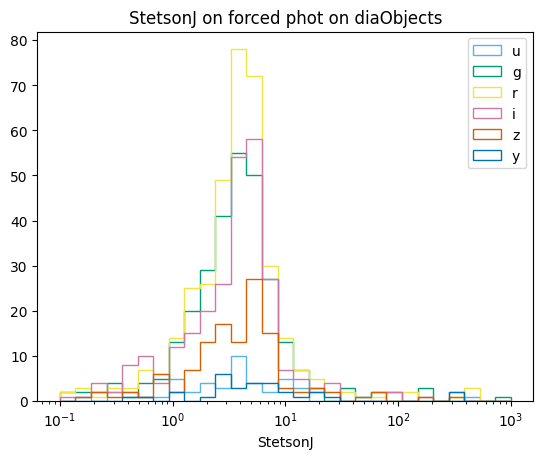

In [261]:
plt.figure()
for band in 'ugrizy':
    plt.hist(dia[f'{band}_psfFluxStetsonJ'], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on diaObjects')
plt.xlabel('StetsonJ')

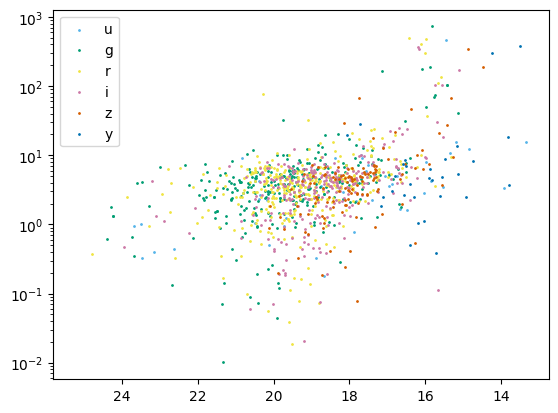

In [262]:
for band in 'ugrizy':
    plt.scatter(dia[f"{band}_psfMag"], dia[f'{band}_psfFluxStetsonJ'], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()

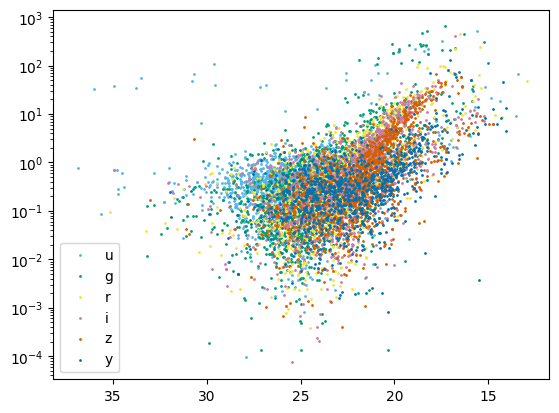

In [264]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(obj[f"{band}_psfMag"], objJs[col], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()

<Axes: >

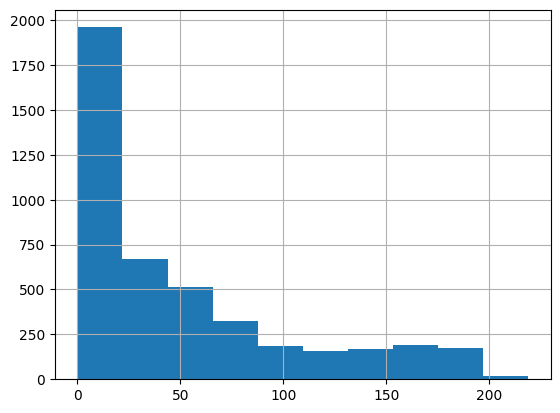

In [270]:
obj['r_nForced'].hist()

In [275]:
obj[f"{band}_nForced"].replace(np.nan, 0)

0       0.0
1       0.0
       ... 
4860    0.0
4861    0.0
Name: u_nForced, Length: 4862, dtype: float64

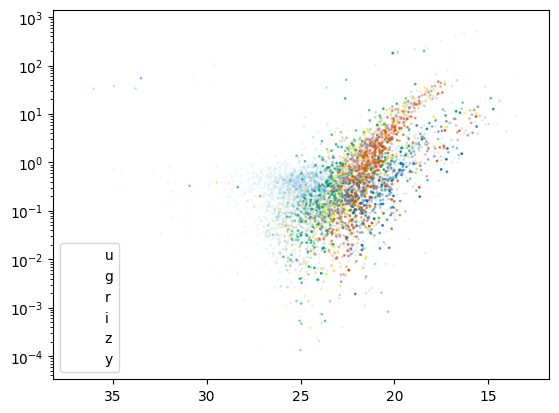

In [284]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(obj[f"{band}_psfMag"], objJs[col], color=COLORS[band], label=band, s=1, alpha=(np.pow(obj[f"{band}_nForced"].replace(np.nan, 0), 2)/np.pow(obj[f"{band}_nForced"].replace(np.nan, 0), 2).max()))
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()

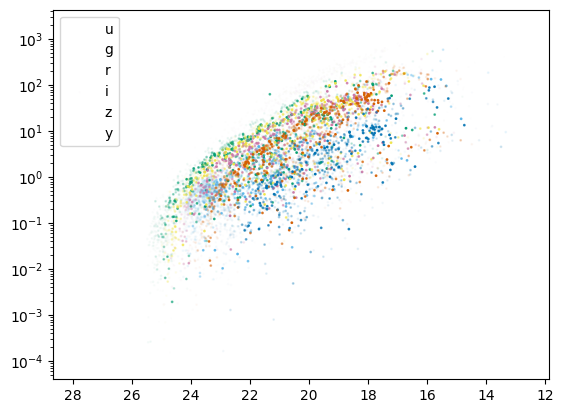

In [285]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(dia[f"{band}_psfMag"], diaJs[col], color=COLORS[band], label=band, s=1, alpha=(np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2)/np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2).max()))
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()

In [307]:
dia

name_X       ra_X      dec_X  e_pos_raw_X      field_X  \
0      2SXPS J023213.2+064951   38.05504    6.83085          4.2      SV_38_7   
1      2SXPS J023213.2+064951   38.05504    6.83085          4.2      SV_38_7   
...                       ...        ...        ...          ...          ...   
2376  1eRASS J023842.8-341701  39.678611 -34.283868     5.144724  Fornax_dSph   
2377  1eRASS J023958.4-340715  39.993688 -34.120846     4.339313  Fornax_dSph   

       cat_X  F_X  e_pos_1sig_X  e_pos_95_X obj_flag_X dia_flag_X  tract_X  \
0      2SXPS  0.0      2.553191    5.004255       True       True    10463   
1      2SXPS  0.0      2.553191    5.004255       True       True    10463   
...      ...  ...           ...         ...        ...        ...      ...   
2376  eRASS1  0.0      5.144724   10.083659       True       True     4016   
2377  eRASS1  0.0      4.339313    8.505054       True       True     4218   

      patch_X DP1_flag_X        dec         diaObjectId  nDiaSources  \
0          50       True   6.830845  648365376786137163           19   
1          50       True   6.831348  648365376786137148            1   
...       ...        ...        ...                 ...          ...   
2376       93       True -34.283769  604064885071937808            1   
2377       17       True -34.121495  605447795821773372            1   

             ra   radecMjdTai  tract  \
0     38.054364  60652.095669  10463   
1     38.054567  60638.125741  10463   
...         ...           ...    ...   
2376  39.675554  60650.178297   4016   
2377  39.994116  60639.271225   4218   

                                  diaObjectForcedSource  \
0     [{parentObjectId: 0, coord_ra: 38.054364, coor...   
1     [{parentObjectId: 0, coord_ra: 38.054567, coor...   
...                                                 ...   
2376  [{parentObjectId: 0, coord_ra: 39.675554, coor...   
2377  [{parentObjectId: 0, coord_ra: 39.994116, coor...   

                                              diaSource  g_psfFluxStetsonJ  \
0     [{visit: 2024112300225, detector: 1, band: 'r'...           2.452126   
1     [{visit: 2024112300221, detector: 0, band: 'r'...               <NA>   
...                                                 ...                ...   
2376  [{visit: 2024120500022, detector: 2, band: 'r'...               <NA>   
2377  [{visit: 2024112400276, detector: 2, band: 'i'...               <NA>   

      r_psfFluxStetsonJ  u_psfFluxStetsonJ  i_psfFluxStetsonJ  \
0              4.580967               <NA>           7.259537   
1                  <NA>               <NA>               <NA>   
...                 ...                ...                ...   
2376               <NA>               <NA>               <NA>   
2377               <NA>               <NA>               <NA>   

      z_psfFluxStetsonJ  y_psfFluxStetsonJ  _dist_arcsec          _healpix_29  \
0                  <NA>               <NA>      2.415297     9629578292811138   
1                  <NA>               <NA>      2.463998     9629578292811138   
...                 ...                ...           ...                  ...   
2376               <NA>               <NA>      9.100868  2531132660334881878   
2377               <NA>               <NA>      2.663922  2531148349742117480   

      u_psfMag   g_psfMag   r_psfMag   i_psfMag   z_psfMag  y_psfMag  \
0         <NA>  18.398947   17.92272  17.391117   17.18124      <NA>   
1         <NA>   19.65543  19.053322  18.657452  18.209721      <NA>   
...        ...        ...        ...        ...        ...       ...   
2376      <NA>  24.190819  23.757906  22.962509       <NA>      <NA>   
2377      <NA>  20.927759  20.633392  20.495371       <NA>      <NA>   

      u_psfFluxForcedStetsonJ  g_psfFluxForcedStetsonJ  \
0                        <NA>                10.529728   
1                        <NA>                13.298576   
...                       ...                      ...   
2376                     <

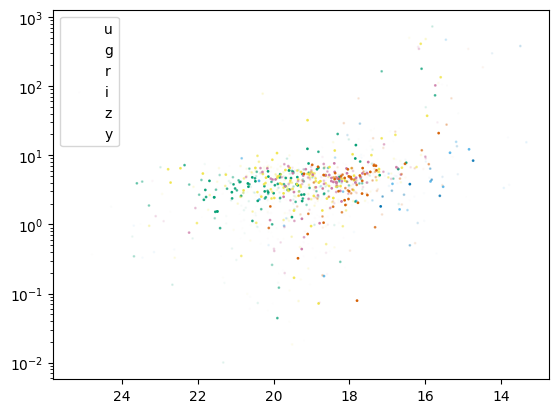

In [308]:
for band in 'ugrizy':
    col = f'{band}_psfFluxStetsonJ'
    plt.scatter(dia[f"{band}_psfMag"], dia[col], color=COLORS[band], label=band, s=1, alpha=(np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2)/np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2).max()))
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()

## Calculate reliability and False alarm probability

In [289]:
counts = pd.read_csv('../data/counts.csv')

In [287]:
obj['norm_dist'] = obj['_dist_arcsec'] / obj['e_pos_1sig_X']

In [292]:
obj['reliability'] = np.exp(-np.pi * obj['_dist_arcsec'] ** 2 * counts['N'])

Text(0.5, 0, 'Reliability')

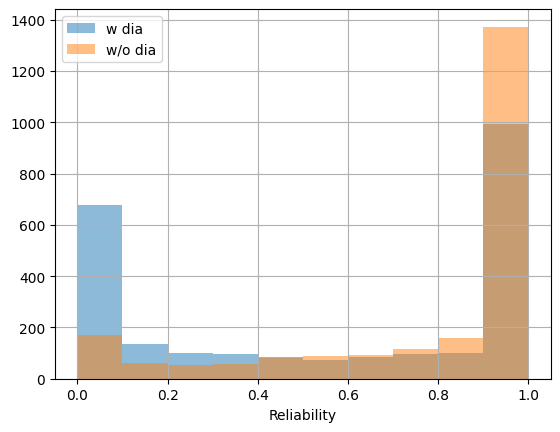

In [303]:
fig, ax = plt.subplots()
obj[obj['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w dia')
obj[~obj['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w/o dia')
plt.legend()
plt.xlabel('Reliability')

In [265]:
obj['i_psfMag']

0       18.644827
1       16.810074
          ...    
4860    21.498226
4861    22.106869
Name: i_psfMag, Length: 4862, dtype: float[pyarrow]

Text(0, 0.5, 'r')

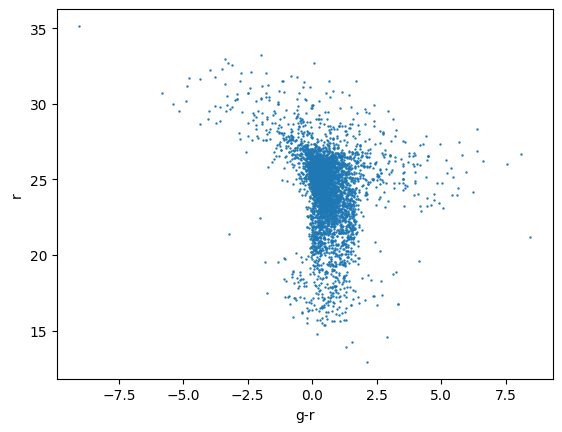

In [267]:
plt.scatter(obj['g_psfMag'] - obj['r_psfMag'], obj['r_psfMag'], s=.5)
plt.xlabel('g-r')
plt.ylabel('r')

Text(0, 0.5, 'r')

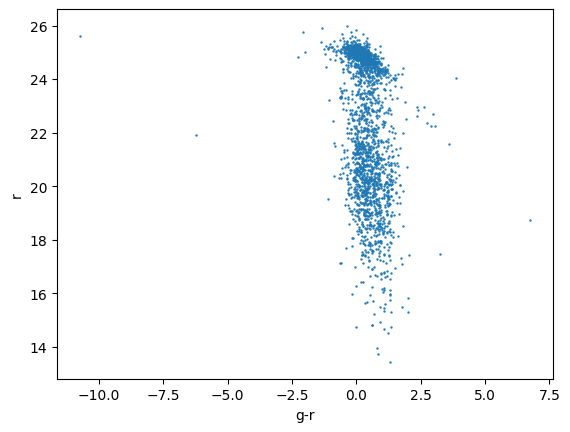

In [268]:
plt.scatter(dia['g_psfMag'] - dia['r_psfMag'], dia['r_psfMag'], s=.5)
plt.xlabel('g-r')
plt.ylabel('r')